# Text Wrangling and Regex

Adapted from Lisa Yan, Will Fithian, Joseph Gonzalez, Deborah Nolan, Sam Lau

Updated by Bella Crouch

Working with text: applying string methods and regular expressions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import pandas as pd

## Demo 1: Canonicalizing County Names

In [4]:
states = pd.read_csv("data/county_and_state.csv")
populations = pd.read_csv("data/county_and_population.csv")

# display allows us to view a DataFrame without returning it as an object
display(states)
display(populations)

,County,State
0,De Witt County,IL
1,Lac qui Parle County,MN
2,Lewis and Clark County,MT
3,St John the Baptist Parish,LS


,County,Population
0,DeWitt,16798
1,Lac Qui Parle,8067
2,Lewis & Clark,55716
3,St. John the Baptist,43044


Both of these DataFrames share a "County" column. Unfortunately, formatting differences mean that we can't directly merge the two DataFrames using the "County"s.

In [5]:
states.merge(populations, left_on="County", right_on="County")

,County,State,Population


### Using Pandas String Functions

To address this, we can **canonicalize** the "County" string data to apply a common formatting.

In [6]:
def canonicalize_county(county_series):
    return (county_series.str.lower()               # lowercase
            .str.replace(' ', '')                   # remove space
            .str.replace('&', 'and')                # replace &
            .str.replace('.', '')                   # remove dot
            .str.replace('county', '')              # remove "county"
            .str.replace('parish', '')              # remove "parish" 
            )

display(canonicalize_county(states["County"]))
display(canonicalize_county(populations["County"]))


0              dewitt
1         lacquiparle
2       lewisandclark
3    stjohnthebaptist
Name: County, dtype: object

0              dewitt
1         lacquiparle
2       lewisandclark
3    stjohnthebaptist
Name: County, dtype: object

In [7]:
states["Canonical County"] = canonicalize_county(states["County"])
populations["Canonical County"] = canonicalize_county(populations["County"])
display(states)
display(populations)

,County,State,Canonical County
0,De Witt County,IL,dewitt
1,Lac qui Parle County,MN,lacquiparle
2,Lewis and Clark County,MT,lewisandclark
3,St John the Baptist Parish,LS,stjohnthebaptist


,County,Population,Canonical County
0,DeWitt,16798,dewitt
1,Lac Qui Parle,8067,lacquiparle
2,Lewis & Clark,55716,lewisandclark
3,St. John the Baptist,43044,stjohnthebaptist


Now, the merge works as expected!

In [8]:
states.merge(populations, on="Canonical County")

,County_x,State,Canonical County,County_y,Population
0,De Witt County,IL,dewitt,DeWitt,16798
1,Lac qui Parle County,MN,lacquiparle,Lac Qui Parle,8067
2,Lewis and Clark County,MT,lewisandclark,Lewis & Clark,55716
3,St John the Baptist Parish,LS,stjohnthebaptist,St. John the Baptist,43044


<br><br><br>

**Return to Lecture**


---

## Demo 2: Extracting Log Data

In [9]:
log_fname = 'data/log.txt'
with open(log_fname, 'r') as f:
    log_lines = f.readlines()
log_lines

['169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n',
 '193.205.203.3 - - [2/Feb/2005:17:23:6 -0800] "GET /stat141/Notes/dim.html HTTP/1.0" 404 302 "http://eeyore.ucdavis.edu/stat141/Notes/session.html"\n',
 '169.237.46.240 - "" [3/Feb/2006:10:18:37 -0800] "GET /stat141/homework/Solutions/hw1Sol.pdf HTTP/1.1"\n']

Suppose we want to extract the day, month, year, hour, minutes, seconds, and timezone. Looking at the data, we see that these items are not in a fixed position relative to the beginning of the string. That is, slicing by some fixed offset isn't going to work.

In [10]:
log_lines[0][20:31] #  20:31 were determined by trial-and-error!

'26/Jan/2014'

What happens if we use the same range for the next log line?

In [11]:
log_lines[1][20:31]

'/Feb/2005:1'

Instead, we'll need to use some more sophisticated thinking. Let's focus on only the first line of the file.

In [12]:
first = log_lines[0]
first

'169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n'

Find the data inside the square brackes by splitting string at the square brackets

In [15]:
pertinent = (
    first.split("[")[1] # remove everything before the first [
    .split(']')[0] # Remove everything after the second square ]
) # find the text enclosed in square brackets
pertinent

'26/Jan/2014:10:47:58 -0800'

In [25]:
day, month,rest  = pertinent.split('/')       # split up the date/month/year 

print("Day:   ", day)
print("Month: ", month)
print("Rest:  ", rest)

Day:    26
Month:  Jan
Rest:   2014:10:47:58 -0800


In [26]:
print(rest)
year, hour, minute, rest = rest.split(':')    # split up the hour:minute:second

print("Year:   ", year)
print("Hour:   ", hour)
print("Minute: ", minute)
print("Rest:   ", rest)

2014:10:47:58 -0800
Year:    2014
Hour:    10
Minute:  47
Rest:    58 -0800


In [19]:
seconds, time_zone = rest.split(' ')          # split the timezone after the blank space
day, month, year, hour, minute, seconds, time_zone

('26', 'Jan', '2014', '10', '47', '58', '-0800')

Try doing the same thing using pandas `str` methods:

Solution below.
<details>
    
```python
df = (
    logs.str.split("[")
        .str[1]
        .str.split("]")
        .str[0]
        .str.split("/", expand=True)
        .rename(columns={0: "Day", 1: "Month", 2: "Rest"})
)
df = (
    df.join(df["Rest"].str.split(":", expand=True))
        .drop(columns=["Rest"])
        .rename(columns={0: "Year", 1: "Hour", 2: "Minute", 3: "Rest"})
)
df = (
    df.join(df["Rest"].str.split(" ", expand=True))
        .drop(columns=["Rest"])
        .rename(columns = {0: "Seconds", 1: "Timezone"})
)

print("Final Dataframe")
display(df)
```

</details>

In [35]:
logs = pd.read_csv("data/log.txt", 
                sep="\t", 
                header=None)[0]

print("Original input!")
display(logs)

import re
# finish me
pattern=r'\[(\d+)/(\w+)/(\d+):(\d+):(\d+):(\d+) (-\d+)\]'
day, month, year, hour, minute, second, time_zone = re.findall(pattern, first)[0]
print(day, month, year, hour, minute, second, time_zone)

Original input!


0    169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...
1    193.205.203.3 - - [2/Feb/2005:17:23:6 -0800] "...
2    169.237.46.240 - "" [3/Feb/2006:10:18:37 -0800...
Name: 0, dtype: object

26 Jan 2014 10 47 58 -0800


This worked and you will often see code like this in data cleaning pipelines.  

However, **regular expressions** provide a faster and more expressive mechanism to extract strings that match certain patterns. 

<br> <br>

**Return to lecture**

<br><br>


---

# Regular Expressions


## String Extraction with Regex

Python `re.findall` returns a list of all extracted matches:

In [36]:
import re

text = "My social security number is 123-45-6789 bro, or actually maybe it’s 321-45-6789.";

pattern = r"[0-9]{3}-[0-9]{2}-[0-9]{4}"

re.findall(pattern, text)

['123-45-6789', '321-45-6789']

<br/>

Now, let's see vectorized extraction in `pandas`:

 `.str.findall` returns a `Series` of lists of all matches in each record.

In [37]:
df_ssn = pd.DataFrame(
    ['987-65-4321',
     'forty',
     '123-45-6789 bro or 321-45-6789',
     '999-99-9999'],
    columns=['SSN'])
df_ssn

,SSN
0,987-65-4321
1,forty
2,123-45-6789 bro or 321-45-6789
3,999-99-9999


In [38]:
# -> Series of lists
pattern = r"[0-9]{3}-[0-9]{2}-[0-9]{4}"
df_ssn['SSN'].str.findall(pattern)

0                 [987-65-4321]
1                            []
2    [123-45-6789, 321-45-6789]
3                 [999-99-9999]
Name: SSN, dtype: object

Extracting the last expression

In [40]:
(
    df_ssn['SSN']
    .str.findall(pattern)
    .str[-1] # Get the last element from each list
)

0    987-65-4321
1            NaN
2    321-45-6789
3    999-99-9999
Name: SSN, dtype: object

<br><br><br>

**Return to slides**



---

<br> <br>


## Extraction Using Regex Capture Groups

The Python function `re.findall`, in combination with parentheses returns specific substrings (i.e., **capture groups**) within each matched string, or **match**.

In [45]:
text = """I will meet you at 08:30:00 pm tomorrow"""       
pattern = ".*(\d+):(\d+):(\d+).*"
matches = re.findall(pattern, text)
matches

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\siriusyz\AppData\Local\Temp\ipykernel_22704\1791086207.py:2: SyntaxWarning: invalid escape sequence '\d'
  pattern = ".*(\d+):(\d+):(\d+).*"


[('8', '30', '00')]

In [46]:
# the three capture groups in the first matched string
hour, minute, second = matches[0]
print("Hour:   ", hour)
print("Minute: ", minute)
print("Second: ", second)

Hour:    8
Minute:  30
Second:  00


<br/>

In `pandas`, we can use `.str.extract` to extract each capture group of **only the first match** of each record into separate columns.

In [47]:
# back to SSNs
df_ssn

,SSN
0,987-65-4321
1,forty
2,123-45-6789 bro or 321-45-6789
3,999-99-9999


In [48]:
# Will extract the first match of all groups
pattern_group_mult = r"([0-9]{3})-([0-9]{2})-([0-9]{4})" # 3 groups
df_ssn['SSN'].str.extract(pattern_group_mult)

,0,1,2
0,987,65,4321
1,NaN,NaN,NaN
2,123,45,6789
3,999,99,9999


When debugging my code with the `str` accessors I often make a separate series varible so the python tab completion tools can find the documentation.

In [50]:
ssns = df_ssn['SSN']
ssns.str.extract(pattern_group_mult) # <- try shift+tab inside the parens

,0,1,2
0,987,65,4321
1,NaN,NaN,NaN
2,123,45,6789
3,999,99,9999


Alternatively, `.str.extractall` extracts **all matches** of each record into separate columns. Rows are then MultiIndexed by original record index and match index.

In [52]:
# -> DataFrame, one row per match
df_ssn['SSN'].str.extractall(pattern_group_mult)

0   1     2
  match               
0 0      987  65  4321
2 0      123  45  6789
  1      321  45  6789
3 0      999  99  9999

<br><br>

**Return to Slides**

<br><br>


---

## Canonicalization with Regex (sub, replace)

In regular Python, canonicalize with `re.sub` (standing for "substitute"):

In [54]:
text = '<div><td valign="top">Moo</td></div>'
pattern = r"<[^>]+>"
re.sub(pattern, '', text)

'Moo'

<br/>

In `pandas`, canonicalize with `Series.str.replace`.

In [55]:
# example dataframe of strings
df_html = pd.DataFrame(['<div><td valign="top">Moo</td></div>',
                   '<a href="http://ds100.org">Link</a>',
                   '<b>Bold text</b>'], columns=['Html'])
df_html

,Html
0,"<div><td valign=""top"">Moo</td></div>"
1,"<a href=""http://ds100.org"">Link</a>"
2,<b>Bold text</b>


In [56]:
# Series -> Series
df_html["Html"].str.replace(pattern, '', regex=True).to_frame()

,Html
0,Moo
1,Link
2,Bold text


<br><br>

**Return to lecture**

<br><br>

# Bonus material


---


# Revisiting Text Log Processing using Regex

### Python `re` version

In [57]:
line = log_lines[0]
display(line)

pattern = r'\[(\d+)\/(\w+)\/(\d+):(\d+):(\d+):(\d+) (.+)\]'
day, month, year, hour, minute, second, time_zone = re.findall(pattern, line)[0] # get first match
day, month, year, hour, minute, second, time_zone

'169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n'

('26', 'Jan', '2014', '10', '47', '58', '-0800')

### `pandas` version

In [58]:
df = pd.DataFrame(log_lines, columns=['Log'])
df

,Log
0,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...
1,"193.205.203.3 - - [2/Feb/2005:17:23:6 -0800] ""..."
2,"169.237.46.240 - """" [3/Feb/2006:10:18:37 -0800..."


Option 1: `Series.str.findall`

In [59]:
pattern = r'\[(\d+)\/(\w+)\/(\d+):(\d+):(\d+):(\d+) (.+)\]'
df['Log'].str.findall(pattern)

0    [(26, Jan, 2014, 10, 47, 58, -0800)]
1      [(2, Feb, 2005, 17, 23, 6, -0800)]
2     [(3, Feb, 2006, 10, 18, 37, -0800)]
Name: Log, dtype: object

<br/>

Option 2: `Series.str.extractall`

In [89]:
newdf=df['Log'].str.extractall(pattern)
newdf

,,0,1,2,3,4,5,6
,match,,,,,,,
0,0,26,Jan,2014,10,47,58,-0800
1,0,2,Feb,2005,17,23,6,-0800
2,0,3,Feb,2006,10,18,37,-0800


Wrangling either of these two DataFrames into a nice format (like below) is left as an exercise for you! You will do a related problem on the homework.


||Day|Month|Year|Hour|Minute|Second|Time Zone|
|---|---|---|---|---|---|---|---|
|0|26|Jan|2014|10|47|58|-0800|
|1|2|Feb|2005|17|23|6|-0800|
|2|3|Feb|2006|10|18|37|-0800|


In [90]:
# your code here
newdf.rename(columns={0:'Day',1:'Month',2:'Year',3:'Hour',4:'Minute',5:'Second',6:'Time Zone'}).reset_index(level='match', drop=True)

,Day,Month,Year,Hour,Minute,Second,Time Zone
0,26,Jan,2014,10,47,58,-0800
1,2,Feb,2005,17,23,6,-0800
2,3,Feb,2006,10,18,37,-0800


<br/><br/>
<br/>

---

# Real World Case Study: Restaurant Data

In this example, we will show how regexes can allow us to track quantitative data across categories defined by the appearance of various text fields.

In this example we'll see how the presence of certain keywords can affect quantitative data:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?** 
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

In [92]:
vio = pd.read_csv('data/violations.csv', header=0, names=['bid', 'date', 'desc'])
desc = vio['desc']
vio.head()

,bid,date,desc
0,19,20171211,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...
3,19,20160513,Unclean or degraded floors walls or ceilings ...
4,19,20160513,Food safety certificate or food handler card n...


In [93]:
counts = desc.value_counts()
counts.shape

(14253,)

That's a lot of different descriptions!! Can we **canonicalize** at all? Let's explore two sets of 10 rows.

In [94]:
counts[:10]

desc
Unclean or degraded floors walls or ceilings                          999
Unapproved or unmaintained equipment or utensils                      659
Inadequately cleaned or sanitized food contact surfaces               493
Improper food storage                                                 476
Inadequate and inaccessible handwashing facilities                    467
Moderate risk food holding temperature                                452
Wiping cloths not clean or properly stored or inadequate sanitizer    418
Moderate risk vermin infestation                                      374
Unclean nonfood contact surfaces                                      369
Food safety certificate or food handler card not available            353
Name: count, dtype: int64

In [95]:
# Hmmm...
counts[50:60]

desc
Unclean or degraded floors walls or ceilings  [ date violation corrected: 11/29/2017 ]              16
Unclean or degraded floors walls or ceilings  [ date violation corrected: 9/19/2017 ]               16
Inadequate HACCP plan record keeping                                                                16
Unclean or degraded floors walls or ceilings  [ date violation corrected: 11/27/2017 ]              15
Unclean or degraded floors walls or ceilings  [ date violation corrected: 12/7/2017 ]               15
Inadequately cleaned or sanitized food contact surfaces  [ date violation corrected: 9/26/2017 ]    14
Unclean or degraded floors walls or ceilings  [ date violation corrected: 11/28/2017 ]              14
Unclean or degraded floors walls or ceilings  [ date violation corrected: 9/6/2017 ]                14
Unapproved or unmaintained equipment or utensils  [ date violation corrected: 9/19/2017 ]           14
Unapproved  living quarters in food facility                        

In [96]:
# Use regular expressions to cut out the extra info in square braces.
vio['clean_desc'] = (vio['desc']
             .str.replace(r'\s*\[.*\]$', '', regex=True)
             .str.strip()       # removes leading/trailing whitespace
             .str.lower())
vio.head()

,bid,date,desc,clean_desc
0,19,20171211,Inadequate food safety knowledge or lack of ce...,inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils,unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...,unapproved or unmaintained equipment or utensils
3,19,20160513,Unclean or degraded floors walls or ceilings ...,unclean or degraded floors walls or ceilings
4,19,20160513,Food safety certificate or food handler card n...,food safety certificate or food handler card n...


In [97]:
# canonicalizing definitely helped
vio['clean_desc'].value_counts().shape

(68,)

In [98]:
vio['clean_desc'].value_counts().head() 

clean_desc
unclean or degraded floors walls or ceilings               3507
moderate risk food holding temperature                     2542
inadequate and inaccessible handwashing facilities         2529
unapproved or unmaintained equipment or utensils           2382
inadequately cleaned or sanitized food contact surfaces    2301
Name: count, dtype: int64

Remember our research question:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?** 
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

<br/>

Below, we use regular expressions and `df.assign()` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html?highlight=assign#pandas.DataFrame.assign)) to **method chain** our creation of new boolean features, one per keyword.

In [99]:
# use regular expressions to assign new features for the presence of various keywords
# regex metacharacter | 
with_features = (vio
 .assign(is_unclean     = vio['clean_desc'].str.contains('clean|sanit'))
 .assign(is_high_risk = vio['clean_desc'].str.contains('high risk'))
 .assign(is_vermin    = vio['clean_desc'].str.contains('vermin'))
 .assign(is_surface   = vio['clean_desc'].str.contains('wall|ceiling|floor|surface'))
 .assign(is_human     = vio['clean_desc'].str.contains('hand|glove|hair|nail'))
 .assign(is_permit    = vio['clean_desc'].str.contains('permit|certif'))
)
with_features.head()

,bid,date,desc,clean_desc,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
0,19,20171211,Inadequate food safety knowledge or lack of ce...,inadequate food safety knowledge or lack of ce...,False,False,False,False,False,True
1,19,20171211,Unapproved or unmaintained equipment or utensils,unapproved or unmaintained equipment or utensils,False,False,False,False,False,False
2,19,20160513,Unapproved or unmaintained equipment or utensi...,unapproved or unmaintained equipment or utensils,False,False,False,False,False,False
3,19,20160513,Unclean or degraded floors walls or ceilings ...,unclean or degraded floors walls or ceilings,True,False,False,True,False,False
4,19,20160513,Food safety certificate or food handler card n...,food safety certificate or food handler card n...,False,False,False,False,True,True


<br/><br/>

### EDA

That's the end of our text wrangling. Now let's do some more analysis to analyze restaurant health as a function of the number of violation keywords.

To do so we'll first group so that our **granularity** is one inspection for a business on particular date. This effectively counts the number of violations by keyword for a given inspection.

In [100]:
count_features = (with_features
 .groupby(['bid', 'date'])
 .sum(numeric_only=True)
 .reset_index()
)
count_features.iloc[255:260, :]

,bid,date,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
255,489,20150728,5,0,2,3,0,0
256,489,20150807,1,0,0,1,0,0
257,489,20160308,2,2,1,0,1,0
258,489,20160721,2,1,1,1,0,1
259,489,20161220,3,0,1,2,0,0


Check out our new dataframe in action:

In [104]:
count_features[count_features['is_vermin'] > 1].head(5)

,bid,date,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
255,489,20150728,5,0,2,3,0,0
291,527,20170821,1,1,2,1,1,1
1508,2622,20160526,4,2,2,3,0,0
1573,2721,20150422,2,1,2,1,0,0
1746,2945,20150921,2,1,2,2,2,1


Now we'll reshape this "wide" table into a "tidy" table using a pandas feature called `pd.melt` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html?highlight=pd%20melt)) which we won't describe in any detail, other than that it's effectively the inverse of `pd.pivot_table`.

Our **granularity** is now a violation type for a given inspection (for a business on a particular date).

In [103]:
violation_type_df = pd.melt(count_features, id_vars=['bid', 'date'],
            var_name='feature', value_name='num_vios')

# show a particular inspection's results
violation_type_df[(violation_type_df['bid'] == 489) & (violation_type_df['date'] == 20150728)]

,bid,date,feature,num_vios
255,489,20150728,is_unclean,5
12517,489,20150728,is_high_risk,0
24779,489,20150728,is_vermin,2
37041,489,20150728,is_surface,3
49303,489,20150728,is_human,0
61565,489,20150728,is_permit,0


Remember our research question:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?** 
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

<br/>

We have the second half of this question! Now let's **join** our table with the inspection scores, located in `inspections.csv`.

In [105]:
# read in the scores
inspection_df = pd.read_csv('data/inspections.csv',
                  header=0,
                  usecols=[0, 1, 2],
                  names=['bid', 'score', 'date'])
inspection_df.head()

,bid,score,date
0,19,94,20160513
1,19,94,20171211
2,24,98,20171101
3,24,98,20161005
4,24,96,20160311


While the inspection scores were stored in a separate file from the violation descriptions, we notice that the **primary key** in inspections is (`bid`, `date`)! So we can reference this key in our join.

In [106]:
# join scores with the table broken down by violation type
violation_type_and_scores = (
    violation_type_df
    .merge(inspection_df, on=['bid', 'date'])
)
violation_type_and_scores.head(12)

,bid,date,feature,num_vios,score
0,19,20160513,is_unclean,1,94
1,19,20171211,is_unclean,0,94
2,24,20160311,is_unclean,2,96
3,24,20161005,is_unclean,1,98
4,24,20171101,is_unclean,0,98
5,31,20151204,is_unclean,0,98
6,45,20160104,is_unclean,3,78
7,45,20160614,is_unclean,1,84
8,45,20170307,is_unclean,3,88
9,45,20170914,is_unclean,2,85


<br/><br/>

---

Let's plot the distribution of scores, broken down by violation counts, for each inspection feature (`is_clean`, `is_high_risk`, `is_vermin`, `is_surface`).

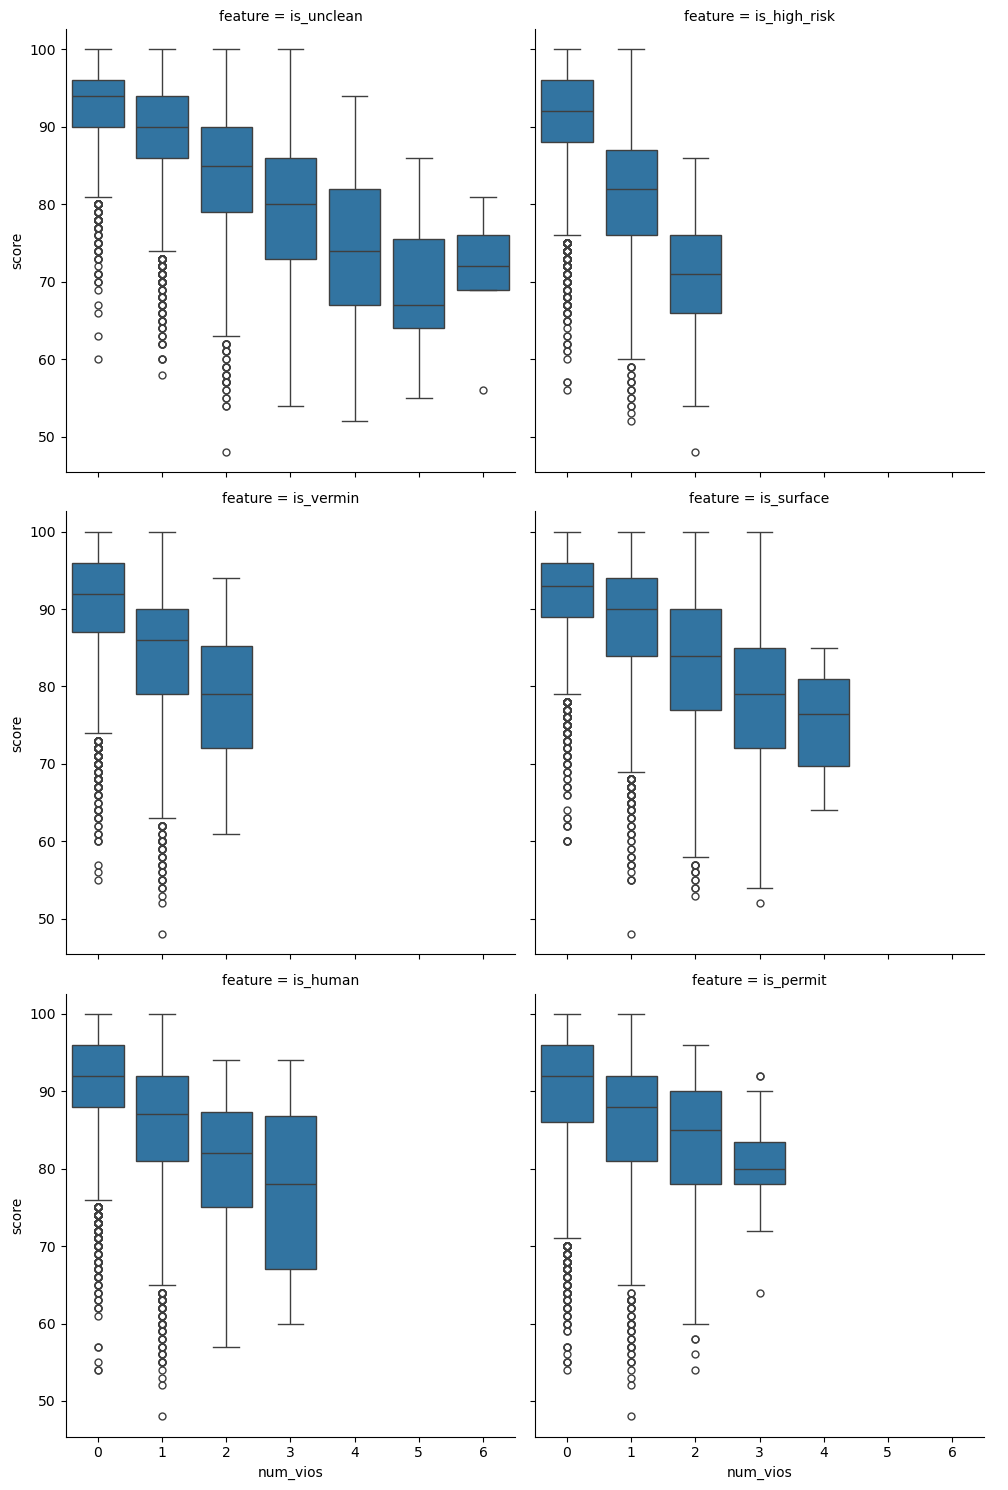

In [107]:
# you will learn this syntax next week. Focus on interpreting for now.
sns.catplot(x='num_vios', y='score',
               col='feature', col_wrap=2,
               kind='box',
               data=violation_type_and_scores);

Above we can observe:
* The inspection score generally goes down with increasing numbers of violations, as expected.
* Depending on the violation keyword, inspections scores on average go down at slightly different rates.
* For example, that if a restaurant inspection involved 2 violations with the keyword "vermin", the average score for that inspection would be a little bit below 80.